# 决策树

- 非参数学习算法
- 天然解决多分类问题
- 也可以解决回归问题
- 非常好的可解释性

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from sklearn import datasets

iris = datasets.load_iris()

In [3]:
print(iris.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

In [6]:
X = iris.data[:, 2:] # 取后两个特征
y = iris.target

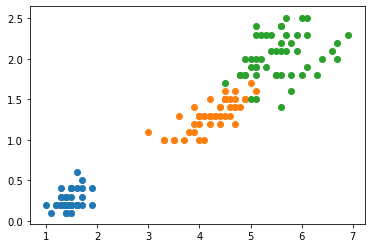

In [7]:
plt.scatter(X[y==0, 0], X[y==0, 1])
plt.scatter(X[y==1, 0], X[y==1, 1])
plt.scatter(X[y==2, 0], X[y==2, 1])

### 1. scikit-learn 中的决策树

In [8]:
from sklearn.tree import DecisionTreeClassifier
# entropy : 熵
dt_clf = DecisionTreeClassifier(max_depth=2, criterion="entropy")
dt_clf.fit(X, y)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=2, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [9]:
def plot_decision_boundary(model, axis):
    
    x0, x1 = np.meshgrid(
        np.linspace(axis[0], axis[1], int((axis[1] - axis[0])*100)).reshape(1, -1),
        np.linspace(axis[2], axis[3], int((axis[3] - axis[2])*100)).reshape(-1, 1)
    )
    X_new = np.c_[x0.ravel(), x1.ravel()]
    
    y_predic = model.predict(X_new)
    zz = y_predic.reshape(x0.shape)
    
    from matplotlib.colors import ListedColormap
    custom_cmap = ListedColormap(['#EF9A9A', '#FFF590', '#90CAF9'])
    
    plt.contourf(x0, x1, zz, linewidth=5, cmap=custom_cmap)

/home/js/pyEnvs/tf_cpu/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: The following kwargs were not used by contour: 'linewidth'
  from ipykernel import kernelapp as app


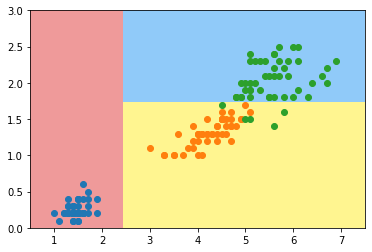

In [10]:
plot_decision_boundary(dt_clf, axis=(0.5, 7.5, 0, 3))
plt.scatter(X[y==0, 0], X[y==0, 1])
plt.scatter(X[y==1, 0], X[y==1, 1])
plt.scatter(X[y==2, 0], X[y==2, 1])

### 2. 如何构建决策树

**问题**

- 每个节点在那个维度做划分？
- 某个维度在那个值上做划分？

- 划分的标准就是，**划分后使得信息熵降低**

**信息熵**

- 熵在信息论中代表随机变量不确定的度量
- 熵越大，数据的不确定性越高
- 熵越小，数据的不确定性越低

$$H = -\sum_{i=1}^kp_i\log{(p_i)}$$
- 其中 $p_i$ 表示每一类信息在所有信息类别中占的比例
![GArxBV.png](https://s1.ax1x.com/2020/03/28/GArxBV.png)
- 对于二分类，香农公式为：
$$H=-x\log(x)-(1-x)\log(1-x)$$

**信息熵函数**

In [11]:
def entropy(p):
    return -p * np.log(p) - (1-p) * np.log(1-p)

In [12]:
x = np.linspace(0.01, 0.99)

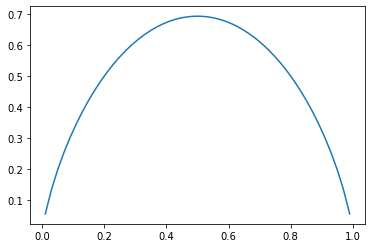

In [13]:
plt.plot(x, entropy(x))

- 可以看出，当 x 越接近0.5，熵越高

### 3. 模拟使用信息熵进行划分

In [14]:
# 基于维度 d 的 value 值进行划分
def split(X, y, d, value):
    index_a = (X[:, d] <= value)
    index_b = (X[:, d] > value)
    return X[index_a], X[index_b], y[index_a], y[index_b]

In [15]:
from collections import Counter
from math import log
# 计算每一类样本点的熵的和
def entropy(y):
    counter = Counter(y)
    res = 0.0
    for num in counter.values():
        p = num / len(y)
        res += -p * log(p)
    return res 

In [16]:
# 寻找要划分的 value 值，寻找最小信息熵及相应的点
def try_split(X, y):
    best_entropy = float('inf') # 最小的熵的值
    best_d, best_v = -1, -1     # 划分的维度，划分的位置
    # 遍历每一个维度
    for d in range(X.shape[1]):
        # 每两个样本点在 d 这个维度中间的值. 首先把 d 维所有样本排序
        sorted_index = np.argsort(X[:, d])
        for i in range(1, len(X)):
            if X[sorted_index[i-1], d] != X[sorted_index[i], d]:
                v = (X[sorted_index[i-1], d] + X[sorted_index[i], d]) / 2
                x_l, x_r, y_l, y_r = split(X, y, d, v)
                # 计算当前划分后的两部分结果熵是多少
                e = entropy(y_l) + entropy(y_r)
                if e < best_entropy: 
                    best_entropy, best_d, best_v = e, d, v
    return best_entropy, best_d, best_v

In [17]:
best_entropy, best_d, best_v = try_split(X, y)
print("best_entropy = ", best_entropy)
print("best_d", best_d)
print("best_v", best_v)

best_entropy =  0.6931471805599453
best_d 0
best_v 2.45


**即在第 0 个维度的 2.45 位置进行划分，可以得到最低的熵，值为 0.693**

In [18]:
X1_l, X1_r, y1_l, y1_r = split(X, y, best_d, best_v)

In [19]:
entropy(y1_r)

0.6931471805599453

In [20]:
entropy(y1_l)  # 从上图可以看出，粉红色部分只有一类，故熵为 0

0.0

In [21]:
best_entropy2, best_d2, best_v2 = try_split(X1_r, y1_r)
print("best_entropy = ", best_entropy2)
print("best_d", best_d2)
print("best_v", best_v2)

best_entropy =  0.4132278899361904
best_d 1
best_v 1.75


In [22]:
X2_l, X2_r, y2_l, y2_r = split(X1_r, y1_r, best_d2, best_v2)

In [23]:
entropy(y2_r)

0.10473243910508653

In [24]:
entropy(y2_l)

0.30849545083110386